### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use('agg')

%matplotlib inline

In [12]:
import numpy as np

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, LeakyReLU, UpSampling2D, InputLayer, Concatenate, Input, merge, concatenate, Lambda, Reshape, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import tensorflow as tf

import cv2

import matplotlib.pyplot as plt

from random import shuffle
from time import time

from loss import custom_loss
from data_processing import get_data, VOCDataGenerator
from multi_gpu_chekpoint import MultiGPUCheckpointCallback

import pickle

from glob import glob

# Parsing the config

The network config is in `yolov3.cfg`

In [3]:
def parse_config(cfg_path, verbose=False):
    file = open(cfg_path, 'r')
    lines = file.readlines()
        
    # get rid of comments and blank lines and white space
    lines = [x for x in lines if len(x) > 1]
    lines = [x for x in lines if x[0] != '#']
    lines = [x.rstrip().lstrip() for x in lines]

    block = {}
    blocks = []
    
    for line in lines:
        if verbose: print('valuating line: %s' % line)
        
        if line[0] == '[': # new block start
            if len(block) != 0: # if the block inst empty (has data) then reset it
                blocks.append(block)
                block = {}
                
            block['type'] = line[1:-1]
        else:
            key, value = line.split('=')
            key, value = key.rstrip(), value.lstrip()
            block[key] = value

    blocks += [block]
    return blocks

In [4]:
blocks = parse_config('hyper.cfg')

LABELS = ['pottedplant', 'bottle', 'bird', 'cow', 'sofa', 'tvmonitor', 'person', 'chair', 'aeroplane', 'dog', 'diningtable', 'train', 'head', 'hand', 'horse', 'cat', 'bicycle', 'boat', 'car', 'sheep', 'bus', 'motorbike', 'foot']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 3
TRUE_BOX_BUFFER  = 10

### Fix shortcut issue
this is a quick fix for the shortcut issue I was running into but I want to figure out why and how this works so I can create a better implementation.

In [5]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

# The model

(add specific info about the model)

### Questions:
1. Why is padding important in a convolutional layer
2. What is `BatchNormalization` and why is it important
3. What does `bilinear` mean?
4. What is `B X C X H X W` and how is it difforent than other formats
5. What is the difforence between route and shortcut and how are they implemented?
    * see the degradation problem, and an [explaination here](https://www.quora.com/What-are-shortcut-connections-how-do-they-work-and-what-is-their-role-in-the-paper-Deep-Residual-Learning-for-Image-Recognition).
6. What does `space_to_depth_x2` do?
7. What is `true_boxes` and why is it important?

In [6]:
input_layer = blocks[0]
input_shape = (int(input_layer['shape']), 
    int(input_layer['shape']), 
    int(input_layer['channels']))

true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
model_input = Input(input_shape)
x = model_input

skip_connection = None
skip_connection_x = None
output = None
model = None

conv_count = 0

for index, block in enumerate(blocks[1:]):
    print('(%i/%i) processing: %s' % (index, len(blocks) - 2, block['type']))
    
    if block['type'] == 'convolutional':        
        filters = int(block['filters'])
        kernel = int(block['kernel'])
        strides = int(block['strides'])
        
        x = Conv2D(filters, 
                   (kernel, kernel), 
                   strides=(strides, strides), 
                   padding='same', 
                   name='conv_%i' % conv_count,
                   use_bias=False)(x)
        x = BatchNormalization(name='batch_norm_%i' % conv_count)(x)
        x = LeakyReLU(alpha=0.1)(x)
        
        conv_count += 1
        
    if block['type'] == 'maxpooling':
        pool = int(block['pool'])
        
        x = MaxPooling2D(pool_size=(pool, pool))(x)
        
    if block['type'] == 'skip_connection':
        open_connection = int(block['open'])
        
        if open_connection:
            skip_connection = x # hold current x for later
        else:
            skip_connection_x = x # make sure we know what this is for concat
            x = skip_connection # set x to skip connect from earlier
    
    if block['type'] == 'space_to_depth':
        x = Lambda(space_to_depth_x2)(x)
        
    if block['type'] == 'concatenate':
        x = concatenate([x, skip_connection_x])
        
    if block['type'] == 'net':
        x = Conv2D(BOX * (4 + 1 + CLASS), 
            (1, 1), strides=(1, 1), 
            name='conv_%i' % conv_count, 
            padding='same')(x)
        
        x = Model(model_input, x, name='yolo')
        x.summary()
#         plot_model(x, to_file='doc/yolo_model.png')
            
        x = x(model_input)
        output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
        output = Lambda(lambda a: a[0])([output, true_boxes]) # seems like `true_boxes` is just being removed here
        
        model = Model([model_input, true_boxes], output)

(0/22) processing: convolutional
(1/22) processing: maxpooling
(2/22) processing: convolutional
(3/22) processing: maxpooling
(4/22) processing: convolutional
(5/22) processing: convolutional
(6/22) processing: maxpooling
(7/22) processing: convolutional
(8/22) processing: maxpooling
(9/22) processing: convolutional
(10/22) processing: convolutional
(11/22) processing: skip_connection
(12/22) processing: maxpooling
(13/22) processing: convolutional
(14/22) processing: convolutional
(15/22) processing: convolutional
(16/22) processing: convolutional
(17/22) processing: skip_connection
(18/22) processing: convolutional
(19/22) processing: space_to_depth
(20/22) processing: concatenate
(21/22) processing: convolutional
(22/22) processing: net
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 416, 416, 3) 

In [7]:
model.summary()
# plot_model(model, to_file='doc/model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
yolo (Model)                    (None, 13, 13, 140)  3527380     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 13, 13, 5, 28 0           yolo[1][0]                       
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1, 1, 1, 10,  0                                            
__________________________________________________________________________________________________
lambda_2 (

## Predictions
Output and generating predictions

### Output Tensor
![image](https://cdn-images-1.medium.com/max/1600/1*cGfWw6lGmV1xUKRsd--JxQ.png)

Each coordinate is represented like this:
![image.png](https://blog.paperspace.com/content/images/2018/04/bbox_-2.png)
the coordinates are the x, y in the matrix of anchors

The above output will need to be changed into a an array like the one in the image above

### Questions
1. what is the 3rd attribute
2. could you use another network to decrease grid size?
3. what is this doing? `tf.math.exp(prediction[:, :, 2:4]) * anchors`
4. softmax vs sigmoid
5. understand the center functions

In [8]:
# MARK - helper functions
def sigmoid(x):
    return 1. / (1. + np.exp(-x))


def softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)


def center_xy(x, y, grid, row, col):
    grid_h, grid_w = grid
    
    x = (col + sigmoid(x)) / grid_w
    y = (row + sigmoid(y)) / grid_h
    
    return x, y
    
    
def center_hw(h, w, grid, count):
    grid_h, grid_w = grid
    
    # get anchor position (+1 because they are in sets)
    w = ANCHORS[2 * count + 0] * np.exp(w) / grid_w
    h = ANCHORS[2 * count + 1] * np.exp(h) / grid_h

    return h, w

# MARK - main function

def format_prediction(prediction, threshold=0.3):
    """
    :param network_info: first block
    """
    
    h, w, count = prediction.shape[:3]
    grid = h, w
    
    boxes = [] # format: xmin, xmax, ymin, ymax, objectness, classes
    prediction[..., 4] = sigmoid(prediction[..., 4]) # normalize
    """
    the next line is a little confusing, basically what it is doing is:
        * get all boxes
        * expand them
        * multiply by classes
    """
    prediction[..., 5:] = prediction[..., 4][..., np.newaxis] * softmax(prediction[..., 5:]) # softmax and unsqueez    
    prediction[..., 5:] *= prediction[..., 5:] > threshold # filter classes below threashold
    
    for i in range(h):
        for j in range(w):
            for c in range(count):
                current_prediction = prediction[i, j, c]
                classes = current_prediction[5:]
                
                if np.sum(classes) != 0.: # see if there are any classes which are not 0.
                    x, y, width, height = current_prediction[:4]
#                     from IPython.core.debugger import Tracer; Tracer()()
                    
                    x, y = center_xy(x, y, grid, i, j)
                    height, width = center_hw(height, width, grid, c)
                    
                    xmin = x-width/2
                    xmax = x+width/2
                    ymin = y-height/2
                    ymax = y+height/2
                    
                    objectness = prediction[i, j, c, 4]
                    boxes.append((xmin, xmax, ymin, ymax, objectness, classes))
    return boxes

# boxes = format_prediction(train_y[201] * 1., threshold=.6)

In [9]:
colors = [ # yeah I spent a lot of time picking colors :P
    (244, 134, 66),
    (66, 134, 244),
    (216, 216, 216),
    (0, 105, 211), 
    (0, 28, 55),
    (51, 87, 255),
    (218, 247, 166),
] * CLASS

def draw_boxes(image, boxes):
    height, width = image.shape[:2]
    height_scalar = height / IMAGE_H # get difference scalar
    width_scalar = width / IMAGE_W
    height_scalar *= IMAGE_H # multiply by height
    width_scalar *= IMAGE_W
        
    for box in boxes:
        xmin, xmax, ymin, ymax, objectness, classes = box
        xmin = int(xmin * width_scalar)
        xmax = int(xmax * width_scalar) 
        ymin = int(ymin * height_scalar) 
        ymax = int(ymax * height_scalar)
        
        main_class = classes.tolist().index(max(classes))
        
        font = cv2.FONT_HERSHEY_PLAIN
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), colors[main_class], 6)
                            
    return image          

# Loading Weights

We want to create a class that will allow us to load the weights and read chucks of values.

## Questions
1. How are weights stored?
    _either as pickles or similar_
2. beta, gamma, mean, var?
3. why is there no bias needed if there are already weights
    * I think that maybe what the below if statement does is not check for weights but check for `use_bias` which would explain both things
4. does this to check for previos weights or something else? `len(conv_layer.get_weights()) > 1`
5. why are the last layer's weights randomized? 
    * I _think_ this is so that some small training will be able to get a good result
6. what would happen if the weights were less precise (ei float16)?

In [16]:
class WeightReader:
    def __init__(self, file):
        self.weights = open(file, 'rb')
        self.count = 0
        self.headers = np.ndarray(
            shape=(4,), dtype='int32', buffer=self.weights.read(16))
        
    def read(self, size=None):
        if size is None:
            return self.weights.read()
        return self.weights.read(size)
    
    def read_arr(self, size, shape=None, count_inc=None):
        if shape is None:
            shape = (size,)
            
        if count_inc is None:
            count_inc = np.prod(shape)
        
        self.count += count_inc
        
        return np.ndarray(
            shape=shape, dtype='float32', buffer=self.read(size))

In [17]:
weight_reader = WeightReader('yolo.weights')

batch_normalize = True # this would change if we used `use_bias`

for index in range(conv_count + 1):
    conv_layer = model.get_layer('yolo').get_layer('conv_%i' % index)
    try:
        norm_layer = model.get_layer('yolo').get_layer('batch_norm_%i' % index)
    except: # TODO this is a hack
        batch_normalize = False
    
    size = conv_layer.kernel.shape[:2]
    
    filters = conv_layer.filters
    conv_bias = weight_reader.read_arr(filters * 4, shape=(filters,))
    
    if batch_normalize and norm_layer is not None:
        batch_weights = weight_reader.read_arr(
            filters * 12, shape=(3, filters))
        
        # this may have issues? (see https://github.com/allanzelener/YAD2K/blob/master/yad2k.py#L144)
        batch_weight_list = [
            batch_weights[0],  # scale gamma
            conv_bias,  # shift beta
            batch_weights[1],  # running mean
            batch_weights[2]  # running var
        ]
        
        norm_layer.set_weights(batch_weight_list)
        
    last_layer_shape = conv_layer.input_shape
    weights_shape = (*size, last_layer_shape[-1], filters)
    darknet_weight_shape = (filters, weights_shape[2], *size)
    weights_size = np.product(weights_shape)
    
    conv_weights = weight_reader.read_arr(
        weights_size * 4, shape=darknet_weight_shape, count_inc=weights_size)
    
    """
    darknet serialization: (out_dim, in_dim, height, width)
    tensorflow serialization: (height, width, in_dim, out_dim)
    """
    conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
    conv_weights = [conv_weights] if batch_normalize else [
        conv_weights, conv_bias
    ]
    
    conv_layer.set_weights(conv_weights)

print('remaining weights: %f' % (len(weight_reader.read()) / 4))

remaining weights: 404875.000000


# Testing output

average time 0.016377 seconds


True

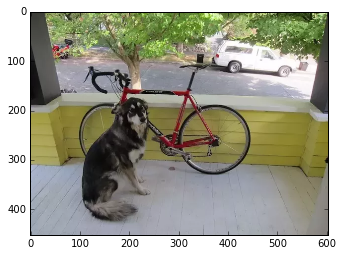

In [52]:
img = cv2.imread("dog-cycle-car.png")
img_input = cv2.resize(img, (416, 416)) # resize to the input dimension
img_input = img_input / 255
img_input = img_input[..., ::-1]
img_input = np.array([img_input])

dummy_array = np.zeros((1, 1, 1, 1, TRUE_BOX_BUFFER, 4))

times = []
for _ in range(10):
    start = time()
    test_prediction = model.predict([img_input, dummy_array])
    times += [time() - start]

print('average time %f seconds' % (sum(times) / len(times)))

boxes = format_prediction(test_prediction[0], threshold=0.1)
img = draw_boxes(img, boxes)
plt.imshow(img[..., ::-1])
cv2.imwrite('doc/example.png',img)

# Custom loss (loss.py)
**TODO** write this

# Training the network

### Questions
1. Why does `exploding gradient` problem happen? Why does clipping values fix it
2. Warm up epochs? Turns out the person who implemented them in the loss function doesnt know how or why they are there -- figure out why they need to be here (kinda part of loss)
    * they allow the network to train more agresively and ignore certain factors (hight and widht I think) so they "learn the data" more quickly before it starts more precice training

## Loading the data

Load the images from the bloodcells dataset

In [53]:
# model.get_layer('yolo').load_weights('model_weights.h5')

# clipvalue=1, clipnorm=1 is for the exploding gradient problem
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipvalue=1., clipnorm=1.)
model.compile(loss=custom_loss, optimizer=optimizer) # , metrics=['accuracy']

ann_glob = glob('VOCdevkit/VOC2012/Annotations/*')
training_generator = VOCDataGenerator(ann_glob)

for i in range(1):
    model.fit_generator(generator=training_generator,
                    # validation_data=validation_generator,
                    epochs=15,
                    use_multiprocessing=False,
                    workers=32)

    model.get_layer('yolo').save_weights('weights/model_weights.h5', overwrite=True)
    model.save('weights/full_model.h5')

Epoch 1/15
1070/1070 [==============================] - 353s 330ms/step - loss: 0.0410
Epoch 2/15
1070/1070 [==============================] - 340s 318ms/step - loss: 0.0387
Epoch 3/15
1070/1070 [==============================] - 340s 318ms/step - loss: 0.0390
Epoch 4/15
 688/1070 [==================>...........] - ETA: 2:01 - loss: 0.0386

KeyboardInterrupt: 

In [18]:
model.get_layer('yolo').save_weights('model_weights.h5', overwrite=True)

In [20]:
img = test_x[5]
img_input = img[..., ::-1]
img_input = np.array([img_input])

dummy_array = np.zeros((1, 1, 1, 1, TRUE_BOX_BUFFER, 4))

test_prediction = model.predict([img_input, dummy_array])

boxes = format_prediction(test_prediction[0], threshold=.13)
# print(boxes)

img = draw_boxes((img * 255).astype(np.uint8).copy() , boxes)
img = img[..., ::-1]

plt.imshow(img)
# cv2.imwrite('cell.png',img)

NameError: name 'test_x' is not defined